# Lab 5: Robust Mixture Models

The goal of this lab session is to study robust mixture models. You will code the EM algorithm to estimate the parameters of a mixture of multivariate t-distributions. 

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before October 31 at 23:59. Please put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [52]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
#import seaborn as sns
import math
%matplotlib inline
#sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

### $t$MM

Reference: https://people.smp.uq.edu.au/GeoffMcLachlan/pm_sc00.pdf 

1 - Prove that in the $t$MM model

$$U_i|(X_i=x_i,Z_{ij}=1) \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)$$

2 - Fill in the following class to implement EM for a multivariate $t$MM. You can use the gamma and digamma functions and also a solver to find roots. 

In [183]:
class my_tMM():
    
    def __init__(self, K, itermax=10, tol=1-4):
        '''
        Parameters:
        -----------
        K: integer
            number of components
        
        Attributes:
        -----------
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        u_: (n, K) np.array
            expectation of the U variable 
        dof_: (K, ) np.array
            degrees of freedom of each component
        labels_: (n, ) np.array
            labels for data points
        '''
        
        self.K_ = K
        self.itermax_ = itermax
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.dof_ = None
        self.u_ = None
        self.tol_ = tol
        
    def sqr_mahalanobis(self, x, mu, Sigma):
        # compute the squared Mahalanobis distance
        return (x - mu).T @ np.linalg.pinv(Sigma) @ (x - mu)
    
    def student_pdf(self, x_i, mu, Sigma, dof):
        """
        Compute the PDF of a multivariate Student's t-distribution of parameters mu, Sigma and dof
        evaluated in point x_i.
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        dof: 
        
        Returns:
        -----
        Evaluation of the PDF
        """
        from scipy.special import gamma
        
        p = x_i.shape[0]
        
        num = gamma((dof + p)/2)*1/(np.sqrt(np.linalg.det(Sigma)) + 1e-3)
        den = (np.sqrt(np.pi*dof)**p * gamma(dof/2) * 
               np.sqrt(1 + self.sqr_mahalanobis(x_i, mu, Sigma)/dof)**(dof+p))
        
        return num/den
    
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        n = X.shape[0]
        p = X.shape[1]
        self.has_converged = False
        
        # Initialize parameters estimators
        self.cond_prob_, self.u_, self.alpha_, self.mu_, self.Sigma_, self.dof_ = self.init_params(X, self.K_)
        
        itr = 0
        while itr < self.itermax_: # and not self.has_converged 
            itr += 1
            # E-step: update cond_prob_ and u_
            new_cond_prob = self.compute_proba(X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_, dof=self.dof_)
            new_u = self.update_u(X=X, cpm=new_cond_prob, mu=self.mu_, Sigma=self.Sigma_, dof=self.dof_)
            
            # M-step: update parameters estimators
            #      - alpha the proportions of the clusters
            #      - mu and Sigma values for maximizing the likelihood
            #      - the degrees of freedom variable
            new_alpha = np.sum(new_cond_prob, axis=0) / n
            new_mu = self.update_mu(X=X, cpm=new_cond_prob, u=new_u)
            new_Sigma = self.update_Sigma(X=X, cpm=new_cond_prob, mu=new_mu, u=new_u)
            new_dof = self.update_dof(cpm=new_cond_prob, p=p, old_dof=self.dof_, u=new_u)
            
            old_params = (self.cond_prob_, self.mu_, self.Sigma_, self.dof_)
            new_params = (new_cond_prob, new_mu, new_Sigma, new_dof)
            
            self.cond_prob_ = new_cond_prob
            self.u_ = new_u
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
            self.dof_ = new_dof
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
        
        # Update labels
        self.labels_ = self.predict(X)
        return self
    
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma, dof):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """        
        n = X.shape[0]
        k = self.K_

        prob_matrix = np.zeros(shape=(n, k))

        for i in range(n):
            joint_law = 1e-3  # To prevent division by 0
            x_i = X[i]
            for j in range(k):
                #print(alpha[j], self.student_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j], dof=dof))
                prob_matrix[i, j] = alpha[j] * self.student_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j], dof=dof[j])
                joint_law += prob_matrix[i, j]
            prob_matrix[i, :] /= joint_law
        
        return prob_matrix
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """       
        from sklearn.cluster import KMeans
        
        n = X.shape[0]
        p = X.shape[1]
        
        # k_means = KMeans(n_clusters=K).fit(X)
        # X_labels = k_means.labels_
        # alpha0 = np.unique(X_labels, return_counts=True)[1] / n
        # cond_prob0 = np.zeros(shape=(n, K))
        # for i in range(n):
        #    cond_prob0[i, X_labels[i]] = 1
        cond_prob0 = np.ones(shape=(n, K)) / K
        alpha0 = np.ones(shape=(K, )) / K
        u0 = np.ones((n, K)) / K

        mu0 = self.update_mu(cpm=cond_prob0, X=X, u=u0)
        Sigma0 = self.update_Sigma(cpm=cond_prob0, X=X, mu=mu0, u=u0)
        
        dof0 = self.update_dof(cpm=cond_prob0, p=p, old_dof=np.ones(shape=(K)), u=u0)
        
            
        return (cond_prob0, u0, alpha0, mu0, Sigma0, dof0)
    
    def update_mu(self, X, cpm, u):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = cpm.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]

        new_mu = np.zeros(shape=(k, p))

        for j in range(k):
            for i in range(n):
                new_mu[j] += X[i] * cpm[i, j] * u[i, j]
            new_mu[j] /= np.sum(np.multiply(cpm,u)[j])

        return new_mu

    def update_Sigma(self, X, cpm, mu, u):
        """Returns the updated version of Sigma (cluster mean covariances)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = cpm.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            for i in range(n):
                deviation = X[i] - mu[j]
                new_Sigma[j] += deviation @ deviation.T * cpm[i, j] * u[i, j]
            new_Sigma[j] /= np.sum(cpm[j])
        
        return new_Sigma
    
    def function_dof(self, dof, old_dof, cond_prob, u, k, p):
        # function to find dof
        from scipy.special import digamma as psi
        
        num = cond_prob[:,k].T @ (np.log(u) - u)[:,k]
        den = cond_prob[:,k].T @ np.ones((cond_prob.shape[0],1))
        
        return -psi(dof/2) + np.log(dof/2) + 1 + psi((old_dof+p)/2) - np.log((old_dof+p)/2) + num/den
        
    
    def update_dof(self, cpm, p, old_dof, u):
        """Returns the updated version of dof (cluster mean degree of liberty)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix
            
        p: int
            The dimension of the data
        
        old_dof: (k, ) np.array
            Old estimators for the clusters' degree of freedom
        
        u: (n, k) np.array
            Current estimators for the clusters' latent variable u
        
        Returns:
        -----
        (k, ) np.array
            New estimators for clusters' degree of freedom
        """
        from scipy.optimize import root_scalar
        
        n = cpm.shape[0]
        k = cpm.shape[1]
        
        new_dof = np.zeros(shape=(k, ))
        
        for j in range(k):
            new_dof[j] = root_scalar(self.function_dof, args=(old_dof[j], cpm, u, j, p), x0=old_dof[j], x1=100).root
        
        return new_dof
    
    def update_u(self, X, cpm, mu, Sigma, dof):
        """Returns the updated version of u
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (n, k) np.array
            The new u
        """
        n = cpm.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_u = np.zeros(shape=(n, k))
        
        for j in range(k):
            for i in range(n):
                num = dof[j]+p
                den = dof[j] + (X[i]-mu[j]).T @ np.linalg.pinv(Sigma)[j] @ (X[i]-mu[j])
                new_u[i,j] = num/den
        
        return new_u
    
    def gauss_pdf(self, x_i, mu, Sigma):
        """
        Computes the PDF of a Gaussian of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PFD
        """
        C = 1/(np.sqrt(2 * np.pi * np.linalg.det(Sigma)))
        Sigma_inv = np.linalg.pinv(Sigma)
        #print(C, Sigma, np.linalg.det(Sigma))
        exp = np.exp(-0.5 * (x_i - mu).T@Sigma_inv@(x_i - mu))
        return C * exp
    
    def gamma_pdf(self, x, lbda, theta):
        """
        Computes the PDF of a Gamma distribution of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PDF
        """
        from scipy.special import gamma as GAMMA
        
        num = x**(lbda-1) * np.exp(-x/theta)
        den = GAMMA(lbda)*theta**lbda
        
        return num/den
    
    def log_likelihood(self, X, cpm, mu, Sigma, dof):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
            
        dof: (k, ) np.array
            Current estimators for clusters' degree of freedom
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = cpm.shape[1]
        
        for i in range(n):
            x_i = X[i]
            for j in range(k):
                if np.argmax(cpm[i])==j:
                    PDF_1 = self.gauss_pdf(x_i, mu=mu[j], Sigma=Sigma[j])

                    lbda = (dof[j]+p)/2
                    theta = 0.5 * (x_i-mu[j]).T @ np.linalg.pinv(Sigma)[j] @ (x_i-mu[j])
                    PDF_2 = self.gamma_pdf(x_i, lbda, theta)
                    PDF_3 = cpm[i,j]
                    l += np.log(PDF_1*PDF_2*PDF_3)
        return l
    
    
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        labels = np.zeros(shape=(n,))
        cond_prob_mat = self.compute_proba(X, self.alpha_, self.mu_, self.Sigma_, self.dof_)
        for i in range(n):
            labels[i] = np.argmax(cond_prob_mat[i, :])
        return labels

3 - Generate one dataset with mixtures of t-distributions that ilustrate when tMM and GMM behave similarly and another dataset where tMM has a better performance

In [45]:
n = 500
p = 2

sigma1 = np.array([3, 1])

sigma2 = np.array([1, 3])

cluster1 = np.random.normal(loc=np.zeros(shape=(p,)),
                            scale=sigma1, size=(n, p))
cluster2 = np.random.normal(loc=np.zeros(shape=(p,)),
                            scale=sigma2, size=(n, p))

data = np.concatenate((cluster1, cluster2), axis=0)

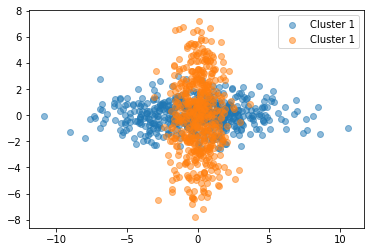

In [101]:
plt.scatter(cluster1.T[0], cluster1.T[1], alpha=0.5, label='Cluster 1')
plt.scatter(cluster2.T[0], cluster2.T[1], alpha=0.5, label='Cluster 1')
plt.legend()
plt.show()

In [184]:
tmm = my_tMM(2)
tmm.fit(data)

C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in log
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\scipy\optimize\zeros.py:346: RuntimeWarning: invalid value encountered in greater
  if abs(q1) > abs(q0):
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\scipy\optimize\zeros.py:330: RuntimeWarning: invalid value encountered in less
  if abs(q1) < abs(q0):
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\ipykernel_launcher.py:371: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\numpy\linalg\linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\numpy\linalg\linalg.py:1942: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\ipyker

In [185]:
tmm.cond_prob_

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

4 - Modify the my_GMM class to implement the Extra Uniform Cluster Algorithm

5 - Modify the my_GMM class to implement the trimmed EM for GMM

6 - Compare the 4 methods in one example

**BONUS (not graded):** Implement the trimming EM clustering algorithm TCLUST (https://arxiv.org/pdf/0806.2976.pdf) 